In [119]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [120]:
# define date parser
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# read csv file (set date column as index)
df = pd.read_csv(
    './data/energy-charts_Stromproduktion_und_Börsenstrompreise_in_Deutschland_2020_Excel.csv',
    delimiter=';', parse_dates=['Datum (MT+1)'], date_parser=d_parser
    # index_col='Datum (MT+1)'
)

In [121]:
# copy df to edit df
energy_df = df.copy()

# rename date column
energy_df.rename(columns={'Datum (MT+1)': 'Datetime', 'Day Ahead Auktion (DE-LU)': 'Day Ahead Auktion/MWh' }, inplace=True)

In [122]:
# add Date column
energy_df['Date'] = energy_df['Datetime'].dt.date

In [123]:
# add weekday column
energy_df['Day of week'] = energy_df['Datetime'].dt.day_name()

In [124]:
# remove import saldo column, as all values are NaN
energy_df = energy_df.dropna(axis=1, how="all")

In [125]:
# Check if there is any na value in df
energy_df.replace('na', np.nan, inplace=True)
energy_df.replace('NA', np.nan, inplace=True)
energy_df.replace('Missing', np.nan, inplace=True)
print(energy_df.isna().value_counts())

Datetime  Kernenergie  Nicht Erneuerbar  Erneuerbar  Day Ahead Auktion/MWh  Date   Day of week
False     False        False             False       False                  False  False          35136
dtype: int64


In [126]:
# drop duplicates
energy_df.drop_duplicates(inplace=True)

In [127]:
# set Date column as index
energy_df.set_index('Datetime', inplace=True)

In [128]:
energy_df.head(10)

,Kernenergie,Nicht Erneuerbar,Erneuerbar,Day Ahead Auktion/MWh,Date,Day of week
Datetime,,,,,,
2020-01-01 00:00:00,8089.585,29700.989,14524.769,38.60,2020-01-01,Wednesday
2020-01-01 00:15:00,8087.935,29597.398,14407.463,38.60,2020-01-01,Wednesday
2020-01-01 00:30:00,8088.635,29433.049,14537.378,38.60,2020-01-01,Wednesday
2020-01-01 00:45:00,8086.715,29319.558,14695.598,38.60,2020-01-01,Wednesday
2020-01-01 01:00:00,8093.394,29202.803,14902.589,36.55,2020-01-01,Wednesday
2020-01-01 01:15:00,8090.135,29144.575,14898.388,36.55,2020-01-01,Wednesday
2020-01-01 01:30:00,8076.207,29123.509,14975.325,36.55,2020-01-01,Wednesday
2020-01-01 01:45:00,8064.899,29243.764,15021.521,36.55,2020-01-01,Wednesday
2020-01-01 02:00:00,8080.356,29402.351,15004.099,32.32,2020-01-01,Wednesday


In [129]:
energy_df.describe()

,Kernenergie,Nicht Erneuerbar,Erneuerbar,Day Ahead Auktion/MWh
count,35136.000000,35136.000000,35136.000000,35136.000000
mean,6934.673246,33765.069651,27962.757734,30.471738
std,969.703507,11159.545300,12106.069379,17.501029
min,3739.551000,11985.471000,7809.697000,-83.940000
25%,6450.204500,25593.516000,18140.908750,21.750000
50%,6793.422000,32771.112000,26610.473500,30.990000
75%,7834.915000,39948.887250,36752.224000,40.250000
max,8185.779000,68966.183000,69026.970000,200.040000


#### what does it mean when the price is minus?

>Negative Strompreise (oder sehr niedrige Strompreise) kommen im Großhandel dann vor, wenn ein Stromüberschuss besteht. Oder anders gesagt, wenn die Stromerzeugung den Stromverbrauch überschreitet. Eine solche Situation entsteht unter anderem, bei einer sehr hohen Einspeisung mit sehr preisgünstigem Strom aus Wind, wie das im Moment der Fall ist.
[agrarheute](https://www.agrarheute.com/markt/diesel/strompreise-fallen-neue-tiefstaende-stromkunden-gehen-leer-602385)

In [130]:
energy_df.loc[:,['Kernenergie', 'Nicht Erneuerbar', 'Erneuerbar', 'Day Ahead Auktion/MWh']].corr()

,Kernenergie,Nicht Erneuerbar,Erneuerbar,Day Ahead Auktion/MWh
Kernenergie,1.000000,0.407680,-0.135737,0.372776
Nicht Erneuerbar,0.407680,1.000000,-0.459684,0.796859
Erneuerbar,-0.135737,-0.459684,1.000000,-0.512600
Day Ahead Auktion/MWh,0.372776,0.796859,-0.512600,1.000000


### Analization - Day of week and Energy Price

In [131]:
# Name dataframe grouped by weekeday
grp_day_of_week = energy_df.groupby(['Day of week'])

<AxesSubplot: xlabel='Datetime', ylabel='Day Ahead Auktion/MWh'>

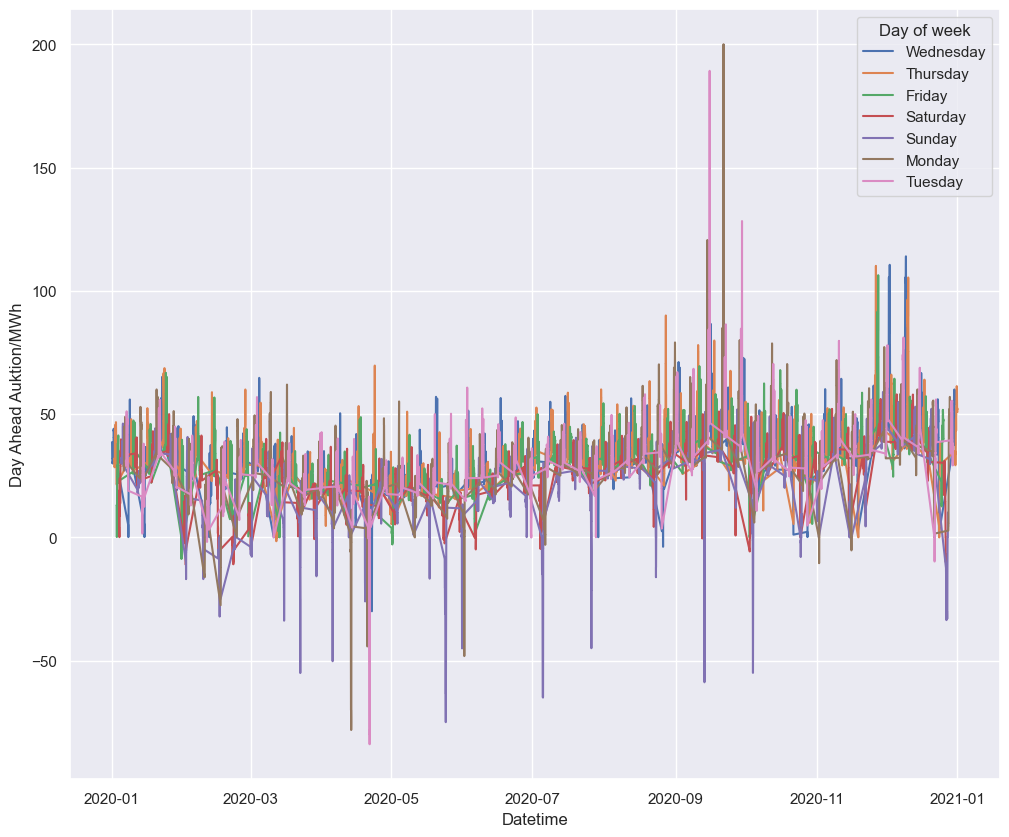

In [132]:
# plot the data
# set figure size
rcParams['figure.figsize'] = 12,10
sns.lineplot(
    x=energy_df.index, 
    y='Day Ahead Auktion/MWh',
    data=energy_df,
    hue='Day of week'
    )
#? How can I plot for each day of week?

In [133]:
# Energy price grouped by day of week
desc = grp_day_of_week['Day Ahead Auktion/MWh'].describe()
# Add a column Q3 - Q1
desc['QD'] = (desc['75%'] - desc['25%']) / 2
# create a series of median and rename column
median = grp_day_of_week['Day Ahead Auktion/MWh'].median()
median.rename('median', inplace=True)

# merge extended description and median 
desc_with_med_and_qd = pd.merge(desc, median, on='Day of week')
desc_with_med_and_qd.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

,count,mean,std,min,25%,50%,75%,max,QD,median
Day of week,,,,,,,,,,
Monday,4992.0,32.391106,18.979678,-78.15,22.6125,33.365,43.2925,200.04,10.34000,33.365
Tuesday,4992.0,33.767548,18.152121,-83.94,24.2775,33.000,42.4600,189.25,9.09125,33.000
Wednesday,5088.0,35.137555,15.999207,-29.98,25.5375,33.785,43.2300,114.00,8.84625,33.785
Thursday,5088.0,35.097586,14.358696,-1.58,25.7650,34.040,43.1850,110.13,8.71000,34.040
Friday,4992.0,33.382268,13.440421,-8.77,24.9200,33.595,41.2525,106.35,8.16625,33.595
Saturday,4992.0,25.210457,12.838657,-11.16,17.1250,26.260,34.0000,58.00,8.43750,26.260
Sunday,4992.0,18.136963,20.075361,-74.97,7.5700,21.445,32.0100,58.97,12.22000,21.445


- Energy price on weekend are lower than on weekdays
- Mean and median are almost the same -> the prices are more or less evenly distributed from the lowest to highest price
- Standard deviation and Q3 - Q1 for this case??

<AxesSubplot: xlabel='Day of week', ylabel='Day Ahead Auktion/MWh'>

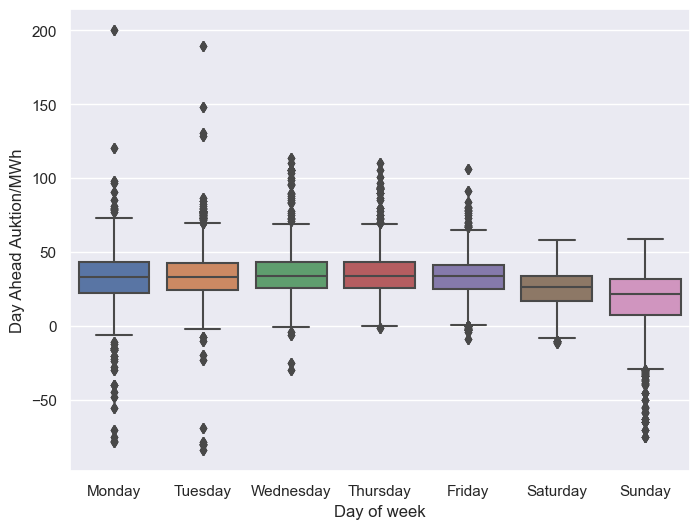

In [134]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x=energy_df['Day of week'], 
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    y=energy_df['Day Ahead Auktion/MWh'] 
    )

- Monday and Tuesday have more outliers compared to the other weekdays -> Prediction for Monday and Tuesday would be more difficult than for other week days.
- Sunday has also relatively many outliers, but they are all lower than the average value
- Weekdays don't seem to have a crutial influence on the energy price.
- Energy price tends to decrease slightly on weekends.
- Energy price on Saturday seem to be most stable.

>Die Preisunterschiede an einem Tag sind unter der Woche stärker ausgeprägt als am Wochenende (einschließlich Feiertage). Von Montag bis Freitag liegen Höchst- und Tiefstpreise stärker auseinander als an Samstagen und Sonntagen. Der Grund dafür ist, dass viele Berufstätige am Wochenende nicht arbeiten und die Kinder zuhause sind. Wann dann etwa jede Familie morgens Kaffee oder Tee kocht, verteilt sich stärker über den Vormittag – an Wochentagen konzentriert sich das auf weniger Stunden am Morgen.
["Wann Du Strom verbrauchst, ist entscheidend für seinen Preis" - finanztip.de](https://www.finanztip.de/stromtarife/variable-stromtarife/)

## Exponential Smoothing

#### Holt-Winters model
- has Trend
- has Seasonality
- Not random

In [135]:
# Exponential smoothing
sr_exp_smoothing = energy_df.copy()
sr_exp_smoothing = sr_exp_smoothing['Day Ahead Auktion/MWh'].resample(rule='D').mean()

sr_exp_smoothing.astype('double')

Datetime
2020-01-01    34.694167
2020-01-02    38.288750
2020-01-03    26.170833
2020-01-04    20.747917
2020-01-05    35.388333
                ...    
2020-12-27   -12.979167
2020-12-28    40.641250
2020-12-29    46.177500
2020-12-30    47.085833
2020-12-31    47.215000
Freq: D, Name: Day Ahead Auktion/MWh, Length: 366, dtype: float64

<AxesSubplot: xlabel='Datetime'>

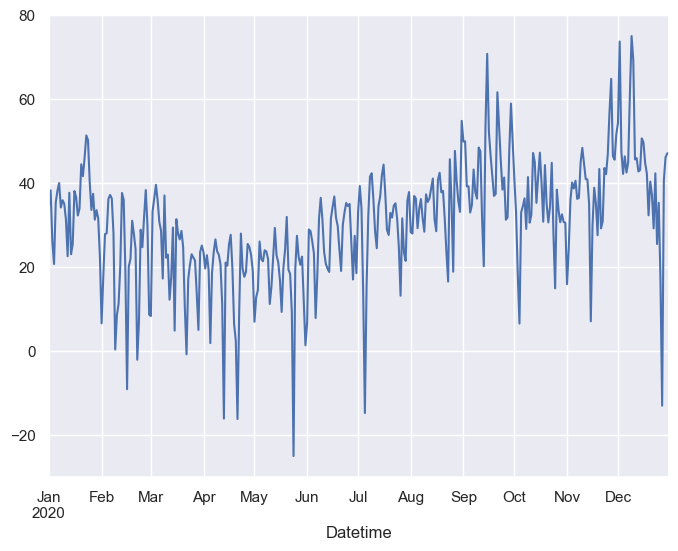

In [136]:
rcParams['figure.figsize'] = 8,6
sr_exp_smoothing.plot()

In [137]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

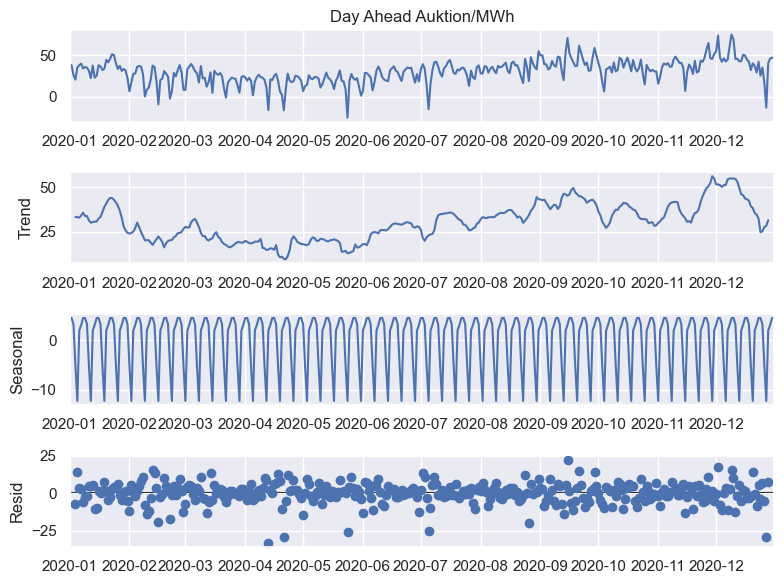

In [138]:
seasonal_decompose(sr_exp_smoothing,model='additive').plot();

In [139]:
# Build a model
model = ExponentialSmoothing(endog=sr_exp_smoothing).fit()

In [140]:
predictions = model.forecast(14)

<AxesSubplot: xlabel='Datetime'>

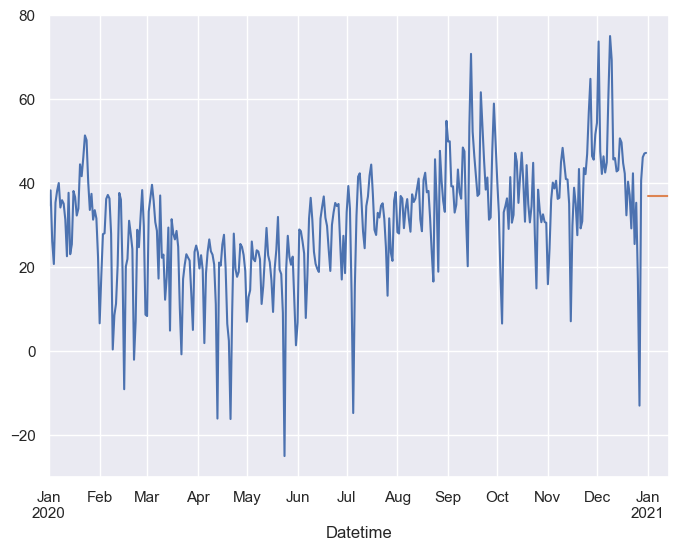

In [141]:
# Plot predictions
sr_exp_smoothing.plot(figsize = (8, 6))
predictions.plot()

In [ ]:
#Commentar